# Event {Class} Demo

In [1]:
from config.settings import ProjectRoot, LocalDataPath, OutPath, PlotsPath, PagesPath, positions, linear_popt
from config.plot_config import set_plot_style; set_plot_style()

from models.event import Event
from models.waveform import Waveform

from utils.functions import linear

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from prettytable import PrettyTable


# Import parameters
from config.run_params_1 import (
                            PEAK_THRESH,
                            INGRESS_THRESH,
                            ROI_t_runs,
                            ROI_t_calib
                            )

In [2]:
run = 1
seg = 4
run_path = os.path.join(LocalDataPath, f"Run{run}")
event = Event(run_path, seg)

if run < 17:
    # Expected signal around zero
    ROI_t = ROI_t_runs
else:
    # Expected signal after zero
    ROI_t = ROI_t_calib

# Get the (relative) timestamp of the event
event.read_timestamp()

# Gather all waveforms from all channels of the segment to a matrix
event.gather_waveforms()

# Set the region of interest and thresholds
event.set_ROI(ROI_t)
event.set_peak_threshold(PEAK_THRESH)
event.set_ingress_threshold(INGRESS_THRESH)

# Set the track parameters
# positions -> height coordinates of plates
# linear_popt -> calibration data for delta_t to x conversion (from calibration.json)
event.set_track_params(positions, linear_popt)

event.calculate_peak_and_ingress()
event.calculate_ingress_matrix()
event.calculate_delta_t_array()
event.calculate_track()

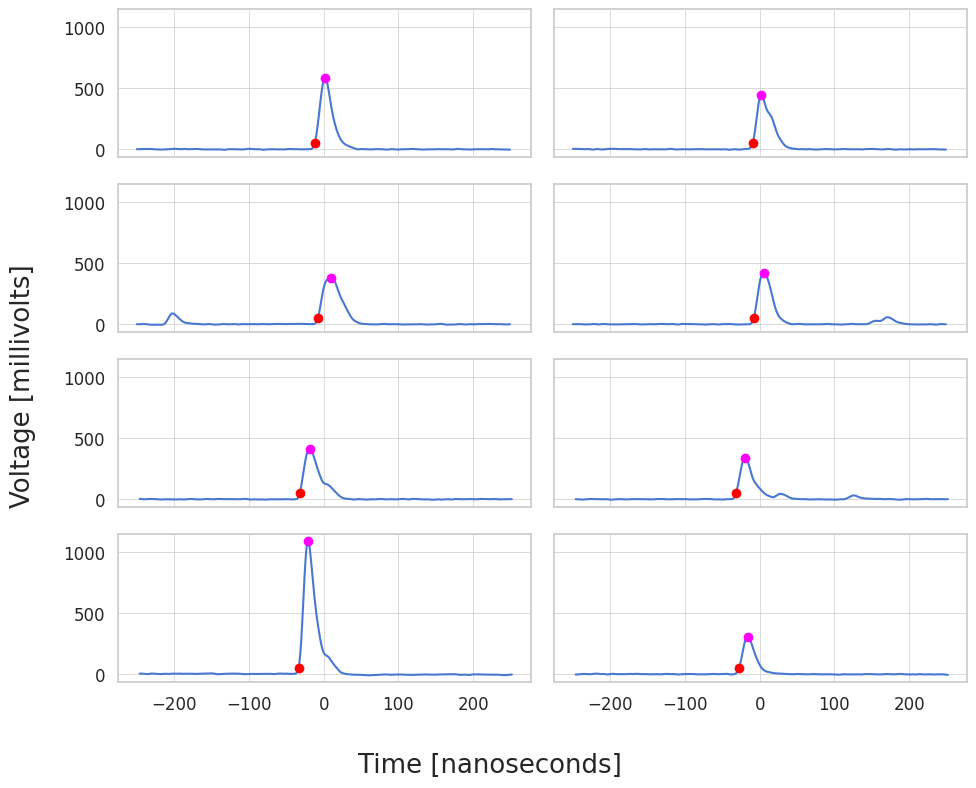

+-----------+-------+
|  Property | Value |
+-----------+-------+
| Timestamp |  0.2  |
|   Angle   | -9.48 |
|    Hits   |   4   |
+-----------+-------+


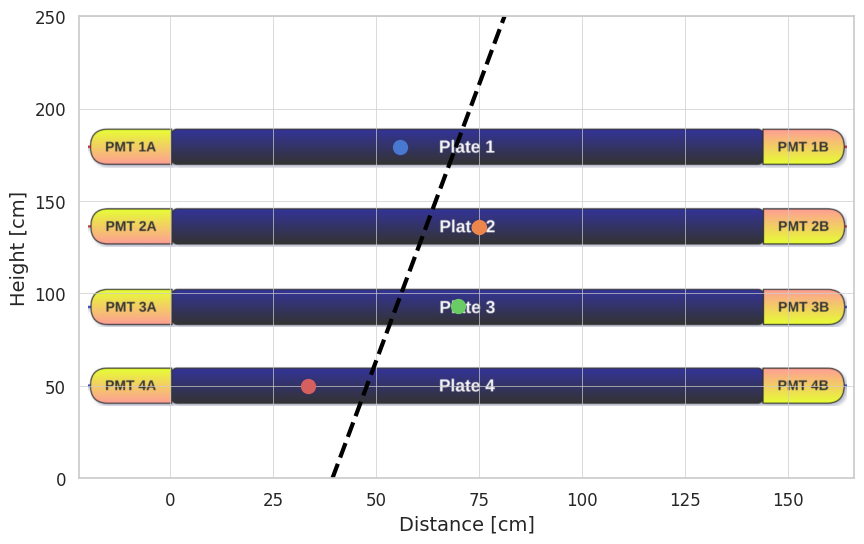

In [3]:
# Get the waveform matrix
mtx = event.get_waveform_matrix()

fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize = (10,8)) 

for i, plate in enumerate(mtx):
    for j in range(2):
        wf = plate[j]
        
        x, y = wf.get_data(zipped=False)
        axs[i][j].plot(x, y)
    
        try:
            peak_idx, peak_val            = wf.get_main_peak()
            axs[i][j].scatter(x[peak_idx], y[peak_idx], 
                                zorder=3, label = f"Peak Bin: {np.round(peak_val,2)} [ns].", color = 'magenta')
        except Exception as e:
            print(e)
            print("No peaks detected")
        
        try:
            ingress_time_val = wf.ingress_val
            axs[i][j].scatter(ingress_time_val, INGRESS_THRESH, 
                    zorder=3, label = f"Ingress Bin: {np.round(ingress_time_val,2)} [ns].", color = 'red')
        except Exception as e:
            print(e)
            print("No ingress detected")

fig.supxlabel("Time [nanoseconds]")
fig.supylabel("Voltage [millivolts]")
fig.tight_layout()
plt.show();


hit_coordinates  = event.hit_coordinates
track_popt       = event.track_popt
hit_bools        = event.get_hit_bools()
timestamp        = np.round(event.get_timestamp(),2)
angle            = np.round(event.get_angle(),2)

data = [
    ["Timestamp", timestamp],
    ["Angle", angle],
    ["Hits", np.sum(hit_bools)]
]

headers = ["Property", "Value"]

table = PrettyTable()
table.field_names = headers
for row in data:
    table.add_row(row)

print(table)

x = np.linspace(0,250)
y = linear(x, *track_popt)

for idx, hit in enumerate(positions):
    plt.scatter(hit_coordinates[idx], hit, s = 100, zorder=3)

# Overlay the image at specific coordinates
w = 11
for i_num in range(4):
    img = mpimg.imread(f"{PagesPath}/plate{i_num+1}.png")  # Replace with your image
    plt.imshow(img, extent=[-20, 164, positions[i_num]-w, positions[i_num]+w], aspect='auto', alpha = 0.8)  # Adjust position with extent

plt.xlabel("Distance [cm]")
plt.ylabel("Height [cm]")

plt.xlim(-22, 166)
plt.ylim(0,250)
plt.plot(y,x, lw = 3, color = 'black', linestyle = 'dashed');